# Review-based Music Recommendation System - Fine Tune BERT
by Yuzhou Wu

## Install the neccessary associates and libraries

In [29]:
# install the huggingface transformers
!pip install transformers

In [30]:
!pip install wandb

In [31]:
!pip install nltk

In [32]:
!pip install bs4

In [33]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/rating_prediction')


In [1]:
import torch
import argparse
from transformers import BertTokenizer
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW
import wandb
import glob
from bs4 import BeautifulSoup
import html
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevinzhenshuai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kevinzhenshuai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
# change the current working dir and check
# %cd /content/drive/MyDrive/Colab Notebooks/rating_prediction/
# print('current working dir is {}'.format(os.getcwd()))

Mount the notebook on GPU

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


## Get preprocessed data, if exist, skip to model training/fine tuning section

In [4]:
def get_dataset(processed_data_dir):
    if os.path.exists(processed_data_dir):
        train_processed = dict(np.load(os.path.join(processed_data_dir, "train_bert.npz")))
        valid_processed = dict(np.load(os.path.join(processed_data_dir, "valid_bert.npz")))
        test_processed = dict(np.load(os.path.join(processed_data_dir, "test_bert.npz")))

        train_labels = train_processed["labels"].astype(np.float32)
        valid_labels = valid_processed["labels"].astype(np.float32)
        del train_processed["labels"]
        del valid_processed["labels"]

        train_encodings = train_processed
        valid_encodings = valid_processed
        test_encodings = test_processed

        print(f"=> Loaded pre-processed data from {processed_data_dir}!")

        return train_encodings, valid_encodings, test_encodings, train_labels, valid_labels
    else: 
        raise NotImplementedError

In [5]:
processed_data_dir = './processed'
train_encodings, valid_encodings, test_encodings, train_labels, valid_labels = get_dataset(processed_data_dir)

=> Loaded pre-processed data from ./processed!


## Load and Prepare Dataset

Load dataset into Pandas dataframes and select fileds of interests

In [39]:
# load and preprocess data
total_train_df = pd.read_json("./train.json", lines=True)
test_df = pd.read_json('./test.json', lines=True)

# split into train and validation set
train_df, valid_df = train_test_split(total_train_df, test_size = 0.2, random_state = 42)

In [40]:
print('train set size: {}'.format(len(train_df)))
train_df.head()

train set size: 160000


,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
153248,5,"09 27, 2015",u03549356,Better than expected from an old P.C.fan. Awes...,Five Stars,1443312000,Pop,$8.95,p10577861,13148837,NaN
67802,5,"03 28, 2018",u47382696,Good old school music,Five Stars,1522195200,Jazz,$7.98,p91232752,32439111,NaN
148889,5,"04 24, 2015",u90648201,"Wonderful to hear the old spirituals, delivery...",Five Stars,1429833600,Jazz,$7.98,p26611367,52727907,NaN
103093,5,"12 4, 2016",u48360742,awecome,Five Stars,1480809600,Pop,$9.89,p74392498,47887987,NaN
104681,5,"08 11, 2015",u35451292,Worth your time to listen and enjoy. Take with...,Put a copy in your car for a better rush hiour!,1439251200,Jazz,$14.89,p58571849,76776786,NaN


In [15]:
print('validation set size: {}'.format(len(valid_df)))
valid_df.head()

validation set size: 40000


,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
119737,4,"01 15, 2006",u97014128,I can't help but notice that people think dona...,Decent album,1137283200,Pop,$13.98,p09608072,52079253,NaN
72272,5,"06 9, 2017",u19429623,Excellent,Five Stars,1496966400,Pop,$14.95,p31077493,94739968,NaN
158154,5,"05 10, 2012",u14022356,I can only start by saying WOW ! If this album...,The Magic of Natural Ability,1336608000,Pop,$11.56,p29932381,70320054,NaN
65426,5,"05 9, 2004",u10784805,If you like showoff check out chris from showo...,FME,1084060800,Alternative Rock,$12.97,p50896575,69912366,NaN
30074,5,"05 8, 2006",u52616966,This CD is one of my favorites - and was the f...,Spectacular - buy this!!!,1147046400,Classical,$15.77,p91635054,56966130,NaN


In [16]:
# preprocess fields of data
all_dfs = [train_df, valid_df, test_df]
fillna_fields = ['reviewText', 'summary']
del_fields = ["reviewTime", "unixReviewTime", "reviewHash", "image"]

for df in all_dfs:
  # Fill N/A text with empy string
  for field in fillna_fields:
    df[field].fillna('', inplace=True)

  # Delete unnecessary fields
  for field in del_fields:
    del df[field]

  # concat reviewText and summary as the overall review feature
  df['reviewAll'] = df['summary'] + ' ' + df['reviewText']
  del df['reviewText']
  del df['summary']


C:\Users\kevinzhenshuai\anaconda3\envs\gpu2\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\kevinzhenshuai\AppData\Local\Temp/ipykernel_14744/442363543.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewAll'] = df['summary'] + ' ' + df['reviewText']


In [77]:
# display sample processed dfs
train_df.head(5)

,overall,reviewerID,category,price,itemID,reviewAll
153248,5,u03549356,Pop,$8.95,p10577861,Five Stars Better than expected from an old P....
67802,5,u47382696,Jazz,$7.98,p91232752,Five Stars Good old school music
148889,5,u90648201,Jazz,$7.98,p26611367,Five Stars Wonderful to hear the old spiritual...
103093,5,u48360742,Pop,$9.89,p74392498,Five Stars awecome
104681,5,u35451292,Jazz,$14.89,p58571849,Put a copy in your car for a better rush hiour...


In [78]:
# define ratings as the target variables
train_labels = train_df.overall.to_numpy().astype(np.float32)
valid_labels = valid_df.overall.to_numpy().astype(np.float32)

In [104]:
def html_escaping(text):
    '''html escaping: Html character codes (i.e., &...;) are replaced with an ASCII equivalent'''
    return html.unescape(text)

def to_lower(text):
    '''lower case all words in text'''
    return text.lower()

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', ' ', text)

def remove_url(text):
    '''remove urls'''
    return re.sub(r"http\S+", ' ', text)

def remove_punctuation(text):
    '''Remove punctuation from text'''
    return re.sub(r'[^\w\s]', ' ', text)
        
def denoise_text(text):
    text = str(text) # make sure all inputs are type string
    text = to_lower(text)
    text = strip_html(text)
    text = html_escaping(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    return text

def word_extraction(text):    
    '''removing stopwords from the sentence and tokenize the sentence'''
    stop_words = set(stopwords.words('english'))
 
    word_tokens = word_tokenize(text)
  
    filtered_sentence = ''
    
    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_sentence = filtered_sentence + ' ' + w   
    return filtered_sentence

In [110]:
train_df.reviewAll[0]

'Amazing that I Actually Bought This...More Amazing that I Actually LOVE This! So is Katy Perry\'s new album "Teenage Dream" contrived, derived and unoriginal?  The answer to all three would be a resounding yes! So why on earth in spite of this fact is her new album so unbelievably great????  Well, the answer may be complicated if not impossible to fully answer.  The simple brilliance of Katy Perry would be simplicity and self awareness....thus the brilliant cover art of her nude in clouds that reveal Katy for what she truly is...an absolutely gorgeous young woman with very a simple, straight forward message....give them what they want.  And Katy delivers!!!....Take a song like "Pearl" ...which I believe happens to be the gem of the entire album....it\'s a lush, gaudy, maudlin, tribute to "woman power" and although the lyrics are silly beyond belief,  it may be just the song many girls need these days.  Another winner here is "who am I living for?".....I really liked this song, as it h

Preprocess review texts before tokenization

In [25]:
def html_escaping(text):
    '''html escaping: Html character codes (i.e., &...;) are replaced with an ASCII equivalent'''
    return html.unescape(text)

def to_lower(text):
    '''lower case all words in text'''
    return text.lower()

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', ' ', text)

def remove_url(text):
    '''remove urls'''
    return re.sub(r"http\S+", ' ', text)

def remove_punctuation(text):
    '''Remove punctuation from text'''
    return re.sub(r'[^\w\s]', ' ', text)
        
def denoise_text(text):
    text = str(text) # make sure all inputs are type string
    text = to_lower(text)
    text = strip_html(text)
    text = html_escaping(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    return text

def word_extraction(text):    
    '''removing stopwords from the sentence and tokenize the sentence'''
    stop_words = set(stopwords.words('english'))
 
    word_tokens = word_tokenize(text)
  
    filtered_sentence = ''
    
    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_sentence = filtered_sentence + ' ' + w   
    return filtered_sentence

In [26]:
# text preprocessing
for df in all_dfs:
    df['reviewAll'] = df.reviewAll.apply(lambda x: denoise_text(x))
    df['reviewAll'] = df.reviewAll.apply(lambda x: word_extraction(x))

C:\Users\kevinzhenshuai\AppData\Local\Temp/ipykernel_14744/3904086986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewAll'] = df.reviewAll.apply(lambda x: denoise_text(x))
C:\Users\kevinzhenshuai\AppData\Local\Temp/ipykernel_14744/3904086986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewAll'] = df.reviewAll.apply(lambda x: word_extraction(x))


### Tokenization and input formatting for BERT

In [ ]:
# Tokenization with the BERT special tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

BERT has two constraints:


*  All sentences must be padded or truncated to a single, fixed length.
*  The maximum sentence length is 512 tokens.




(array([2.5187e+04, 7.5860e+03, 3.3620e+03, 1.6500e+03, 8.9600e+02,
        5.1500e+02, 3.2700e+02, 1.7100e+02, 1.1100e+02, 5.7000e+01,
        3.4000e+01, 2.1000e+01, 2.4000e+01, 1.6000e+01, 8.0000e+00,
        9.0000e+00, 7.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.00000e+00, 7.09600e+01, 1.39920e+02, 2.08880e+02, 2.77840e+02,
        3.46800e+02, 4.15760e+02, 4.84720e+02, 5.53680e+02, 6.22640e+02,
        6.91600e+02, 7.60560e+02, 8.29520e+02, 8.98480e+02, 9.67440e+02,
        1.03640e+03, 1.10536e+03, 1.17432e+03, 1.24328e+03, 1.31224e+03,
        1.38120e+03, 1.450

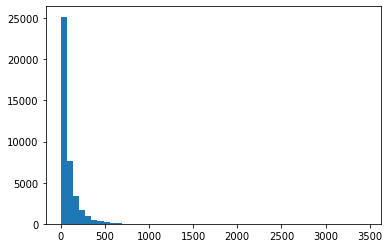

In [138]:
# investigate the maximum length of reviewAll after Tokenization
plt.hist((valid_df['reviewAll'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))).values, bins=50)

In [144]:
(valid_df['reviewAll'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))).describe()

count    40000.000000
mean        83.043925
std        113.504875
min          2.000000
25%         16.000000
50%         44.000000
75%        106.000000
max       3450.000000
Name: reviewAll, dtype: float64

sicne majority of data contain tokenized text of length less than 256 approximately, use MAX_LENGTH = 256 (arbitrarily) for padding and truncation for run time

In [ ]:
# Tokenize reviewText with padding and truncation to max length 256
train_encodings = tokenizer(train_df.reviewAll.tolist(), truncation=True, padding='max_length', max_length=256)
valid_encodings = tokenizer(valid_df.reviewAll.tolist(), truncation=True, padding='max_length', max_length=256)
test_encodings = tokenizer(test_df.reviewAll.tolist(), truncation=True, padding='max_length', max_length=256)
print("=> Loaded and pre-processed data!")

In [ ]:
# save preprocessed data to './processed'
train_processed = dict(train_encodings)
train_processed.update(labels=train_labels)
valid_processed = dict(valid_encodings)
valid_processed.update(labels=valid_labels)
test_processed = dict(test_encodings)

processed_data_dir = './processed'
os.makedirs(processed_data_dir)

np.savez(os.path.join(processed_data_dir, "train_bert.npz"), **train_processed)
np.savez(os.path.join(processed_data_dir, "valid_bert.npz"), **valid_processed)
np.savez(os.path.join(processed_data_dir, "test_bert.npz"), **test_processed)

print(f"=> Save pre-processed data to {processed_data_dir}!")


## Model Training - Fine Tuning

In [6]:
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(sefl, idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [42]:
# arguments variables
class Args: 
    def __init__(self):
        self.batch_size = 12
        self.eval_batch_size = 32
        self.lr = 5e-5
        self.max_epochs = 3
        self.log_steps = 10
        self.eval_steps = 5000
        
        self.processed_data_dir = './processed'
        self.ckpt_dir = '/checkpoint/ywu/'
        self.exp_name = 'bert_finetune'
        self.ckpt_path = ''
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda') 
            print('=> computing on GPU: {}'.format(torch.cuda.get_device_name(0)))
        else:
            self.device = torch.device('cpu')
            print('=> computing on CPU')
        
args = Args()

=> computing on GPU: NVIDIA GeForce GTX 1070


In [17]:
# convert inputs to torch tensor dataset
train_dataset = AmazonDataset(train_encodings, train_labels)
valid_dataset = AmazonDataset(valid_encodings, valid_labels)
test_dataset = AmazonDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)  # already shuffled
valid_loader = DataLoader(valid_dataset, batch_size=args.eval_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.eval_batch_size, shuffle=False)

In [43]:
# define evaluation function to evalulate the performance after each epoch
def eval(step, args, model, valid_loader):
    model.eval()
    losses = []

    # create progress bar by wrapping around epochs
    pbar = tqdm(valid_loader)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        for batch in pbar:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using    
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
            input_ids = batch['input_ids'].to(args.device).long()
            attention_mask = batch['attention_mask'].to(args.device)
            labels = batch['labels'].to(args.device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            pbar.set_description("Eval Loss {:.3f}".format(loss.item()))
            
            losses.append(loss.item())
            
    eval_loss = np.mean(losses)
    print('=> Step: {} Eval loss: {:.6f}'.format(step, eval_loss))
    return eval_loss 

define pretrained BERT model

In [45]:
def get_model(args):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
    print("=> Loaded pretrained model!")
    return model

def get_optimizer(args, model):
    optimizer = AdamW(model.parameters(), lr=args.lr)
    return optimizer

# init visualization with W&B
def init_logger(args):
    wandb.init(project="rate-prediction-BERT",
               name=args.exp_name, config=args, resume=True, id=args.exp_name,
               dir=args.ckpt_dir)

### Training the model

In [48]:
def finetune(args,train_loader, valid_loader, test_loader):
    args.ckpt_dir = os.path.join(args.ckpt_dir, args.exp_name)
    if not os.path.exists(args.ckpt_dir):
        os.makedirs(args.ckpt_dir)

    init_logger(args)
    model = get_model(args)
    model.to(args.device)
    optim = get_optimizer(args, model)


    ckpt_path_all = glob.glob(os.path.join(args.ckpt_dir, "model-*.pt"))
    if len(ckpt_path_all) > 0:
        ckpt_steps = [int(name.split("model-")[1].split(".pt")[0]) for name in ckpt_path_all if "model-best.pt" not in name]
        ckpt_path_last = ckpt_path_all[np.argmax(ckpt_steps)]

        checkpoint = torch.load(ckpt_path_last, map_location='cpu')
        step = checkpoint['step']
        min_eval_loss = checkpoint['min_eval_loss']
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> Loaded checkpoint from '{}' (step {})".format(ckpt_path_last, step))
        if step >= (args.max_epochs * len(train_loader)):
            print(f"=> Finished training (step {step})!")
            return
        start_epoch = step // len(train_loader)
    else:
        step = 0
        min_eval_loss = np.inf
        start_epoch = 0

    model.train()
    for epoch in range(start_epoch+1, args.max_epochs+1):
        pbar = tqdm(train_loader)
        skip_steps = step % len(train_loader)  # only used for starting from checkpoints

        for idx, batch in enumerate(pbar):
            if idx < skip_steps:
                continue

            optim.zero_grad()
            input_ids = batch['input_ids'].to(args.device).long()
            attention_mask = batch['attention_mask'].to(args.device)
            labels = batch['labels'].to(args.device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            pbar.set_description("Epoch {}, Loss {:.3f}".format(epoch, loss.item()))
            loss.backward()
            optim.step()

            step += 1
            if step % args.log_steps == 0:
                wandb.log({"train/loss": loss.item(), 'optim/lr': optim.param_groups[0]['lr']}, step=step)

            if step % args.eval_steps == 0:
                eval_loss = eval(step, args, model, valid_loader)
                wandb.log({"eval/loss": eval_loss}, step=step)

                to_save = {
                    'step': step,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'eval_loss': eval_loss,
                    'min_eval_loss': min_eval_loss,
                }

                save_path = os.path.join(args.ckpt_dir, f"model-{step}.pt")
                torch.save(to_save, save_path)
                print("=> Save checkpoint to '{}' (step {})".format(save_path, step))

                if eval_loss < min_eval_loss:
                    min_eval_loss = eval_loss
                    save_path = os.path.join(args.ckpt_dir, "model-best.pt")
                    torch.save(to_save, save_path)
                    print("=> Save checkpoint to '{}' (step {})".format(save_path, step))

                print("\n")

                model.train()

    eval_loss = eval(step, args, model, valid_loader)
    to_save = {
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'eval_loss': eval_loss,
        'min_eval_loss': min_eval_loss,
    }

    save_path = os.path.join(args.ckpt_dir, f"model-{step}.pt")
    torch.save(to_save, save_path)
    print("=> Save checkpoint to '{}' (step {})".format(save_path, step))
    print(f"=> Finished training (step {step})!")

In [50]:
finetune(args,train_loader, valid_loader, test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=> Loaded pretrained model!


  0%|                                                                                                                                           | 0/13334 [00:00<?, ?it/s]


NameError: name 'self' is not defined